# Abnormalities Prediction Model

### Step 1: Import libraries

In [1]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

C:\Users\rocky\AppData\Local\Temp\ipykernel_36752\852393205.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Step 2: Read dataset

In [2]:
df = pd.read_csv("C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/data/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3. Extracting Pathological Myopia & Normal information from the dataset

##### Abnormalities images

In [3]:
def has_abnormal(text):
    if "myopia" in text:
        return 0
    elif "age" in text:
        return 0
    elif "cataract" in text:
        return 0
    elif "diabetic" in text:
        return 0
    elif "glaucoma" in text:
        return 0
    elif "hypertensive" in text:
        return 0
    else:
        return 1

In [4]:
df["left_abnormal"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_abnormal(x))
df["right_abnormal"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_abnormal(x))

In [8]:
left_abnormal = df.loc[(df.O ==1) & (df.left_abnormal == 1)]["Left-Fundus"].values
left_abnormal[:15]

array(['2_left.jpg', '4_left.jpg', '6_left.jpg', '7_left.jpg',
       '9_left.jpg', '10_left.jpg', '14_left.jpg', '15_left.jpg',
       '17_left.jpg', '21_left.jpg', '26_left.jpg', '27_left.jpg',
       '29_left.jpg', '31_left.jpg', '33_left.jpg'], dtype=object)

In [9]:
right_abnormal = df.loc[(df.O ==1) & (df.right_abnormal == 1)]["Right-Fundus"].values
right_abnormal[:15]

array(['2_right.jpg', '4_right.jpg', '6_right.jpg', '7_right.jpg',
       '9_right.jpg', '10_right.jpg', '14_right.jpg', '15_right.jpg',
       '17_right.jpg', '21_right.jpg', '26_right.jpg', '27_right.jpg',
       '29_right.jpg', '31_right.jpg', '33_right.jpg'], dtype=object)

In [11]:
print("Number of images in left abnormalities: {}".format(len(left_abnormal)))
print("Number of images in right abnormalities: {}".format(len(right_abnormal)))

Number of images in left abnormalities: 1405
Number of images in right abnormalities: 1451


##### Normal images

In [12]:
left_normal = df.loc[(df.O ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(1428,random_state=42).values
right_normal = df.loc[(df.O ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(1428,random_state=42).values

In [15]:
abnormal = np.concatenate((left_abnormal,right_abnormal),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(abnormal),len(normal))

2856 2856


### Step 4: Creating dataset from images

In [14]:
image_set_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [16]:
dataset = create_dataset(abnormal, 1)

100%|██████████| 2856/2856 [00:28<00:00, 101.74it/s]


In [17]:
len(dataset)

2644

In [18]:
dataset = create_dataset(normal, 0)

100%|██████████| 2856/2856 [00:39<00:00, 72.68it/s] 


In [19]:
len(dataset)

5500

##### Image presentation

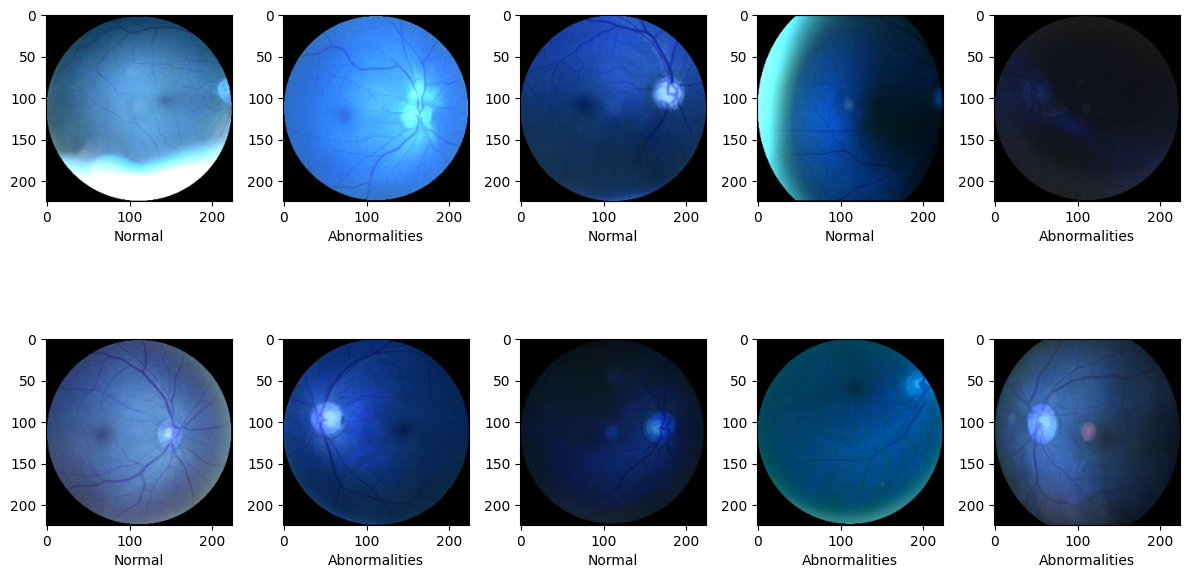

In [21]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Abnormalities"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

##### Dividing dataset into x (features) & y (target)

In [22]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

### Step 5: Creating Model

In [23]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [27]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##### Early stopping for statistical optimization

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [29]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [31]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
138/138 [==============================] - 1104s 8s/step - loss: 2.4556 - accuracy: 0.6145 - val_loss: 1.7109 - val_accuracy: 0.6755
Epoch 2/10
138/138 [==============================] - 1077s 8s/step - loss: 1.1148 - accuracy: 0.7582 - val_loss: 1.2518 - val_accuracy: 0.7300
Epoch 3/10
138/138 [==============================] - 1027s 7s/step - loss: 0.5476 - accuracy: 0.8541 - val_loss: 0.8744 - val_accuracy: 0.7973
Epoch 4/10
138/138 [==============================] - 1120s 8s/step - loss: 0.3068 - accuracy: 0.8984 - val_loss: 0.8612 - val_accuracy: 0.8109
Epoch 5/10
138/138 [==============================] - 1112s 8s/step - loss: 0.1521 - accuracy: 0.9461 - val_loss: 1.2040 - val_accuracy: 0.7773
Epoch 6/10
138/138 [==============================] - 1019s 7s/step - loss: 0.2251 - accuracy: 0.9266 - val_loss: 1.1090 - val_accuracy: 0.8091
Epoch 7/10
138/138 [==============================] - 1126s 8s/step - loss: 0.5130 - accuracy: 0.8814 - val_loss: 1.3774 - val_accuracy:

In [32]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

35/35 [==============================] - 197s 6s/step - loss: 1.2746 - accuracy: 0.7973
loss: 1.2746490240097046
Accuracy: 0.7972727417945862


In [33]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

35/35 [==============================] - 208s 6s/step


In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7972727272727272

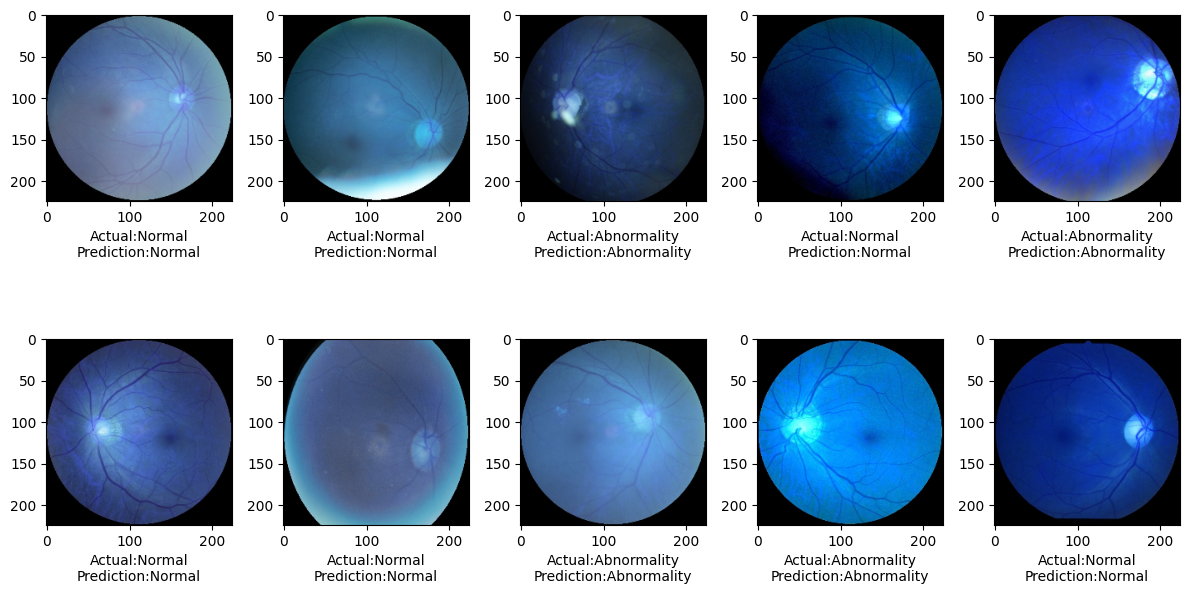

In [38]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Abnormality"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Abnormality"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [39]:
model.save('C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/models/abnormality_model.h5')

c:\Users\rocky\OneDrive\Desktop\Ocular-Disease-Recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
